In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import os

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [5]:
sns.set(style="whitegrid")

In [7]:
tickers = ['AAPL', 'MSFT', 'GOOGL']
start_date = '2015-01-01'
end_date = '2023-12-31'

In [13]:
def fetch_data(ticker):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['Date'] = df.index
    return df[['Date', 'Close']]

In [15]:
stock_data = {ticker: fetch_data(ticker) for ticker in tickers}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
def preprocess(df):
    df = df.copy()
    df = df.iloc[1000:-60, :]
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    return df

In [19]:
preprocessed_data = {ticker: preprocess(df) for ticker, df in stock_data.items()}

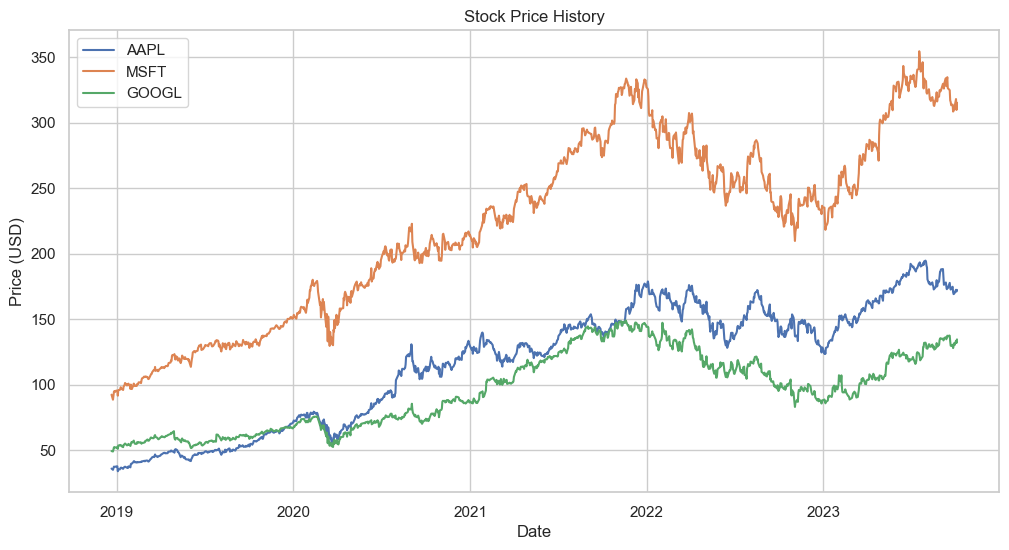

In [21]:
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(preprocessed_data[ticker]['Close'], label=ticker)
plt.title('Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [23]:
data = preprocessed_data['AAPL']
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [25]:
X = []
y = []
time_step = 60
for i in range(time_step, len(data_scaled)):
    X.append(data_scaled[i-time_step:i, 0])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [27]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam())

C:\Users\swamy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.fit(X, y, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0960
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.4326e-04
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0010


In [31]:
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


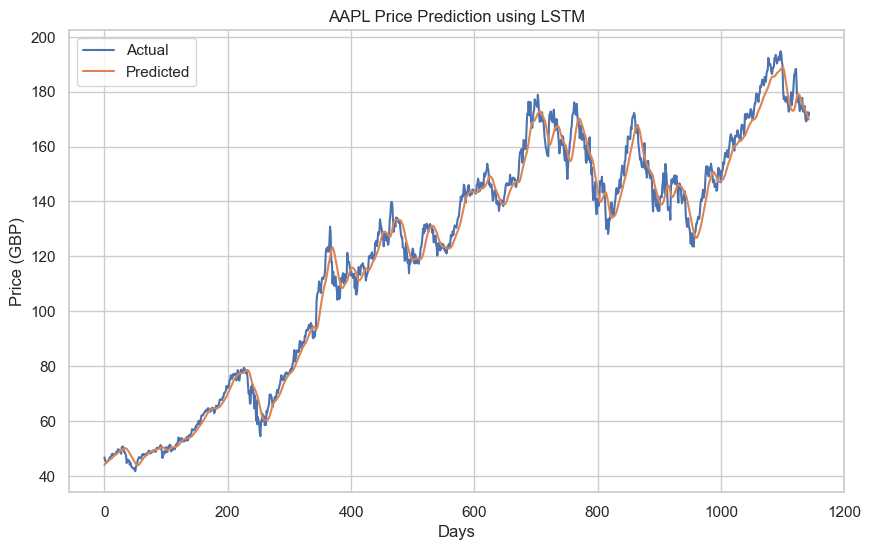

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.title('AAPL Price Prediction using LSTM')
plt.xlabel('Days')
plt.ylabel('Price (GBP)')
plt.legend()
plt.show()


=== Processing AAPL ===


C:\Users\swamy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
AAPL - MAE: 4.1295, RMSE: 5.5653


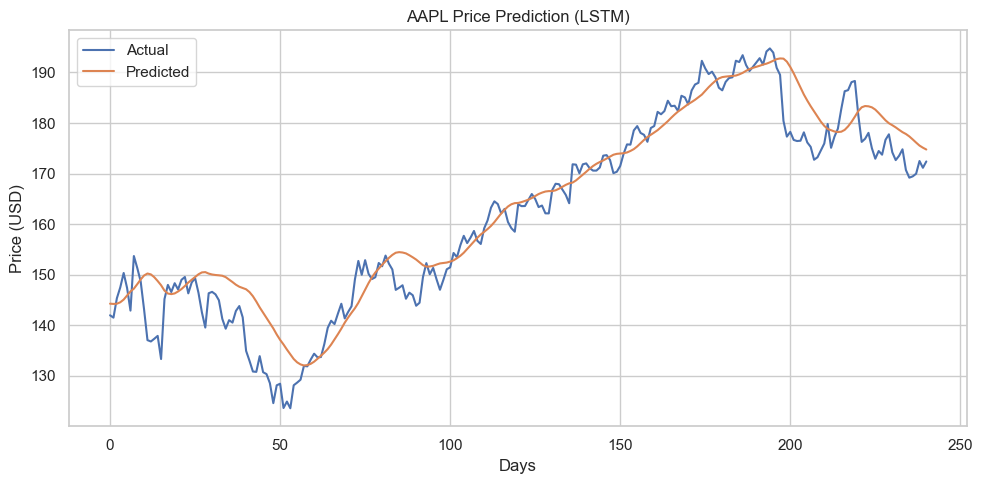


=== Processing MSFT ===


C:\Users\swamy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
MSFT - MAE: 7.2412, RMSE: 8.7145


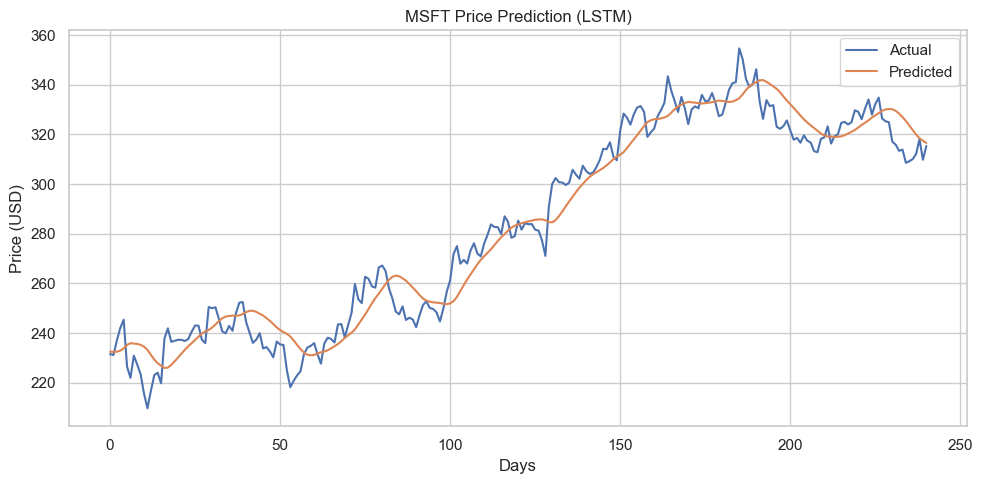


=== Processing GOOGL ===


C:\Users\swamy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
GOOGL - MAE: 4.1204, RMSE: 5.1067


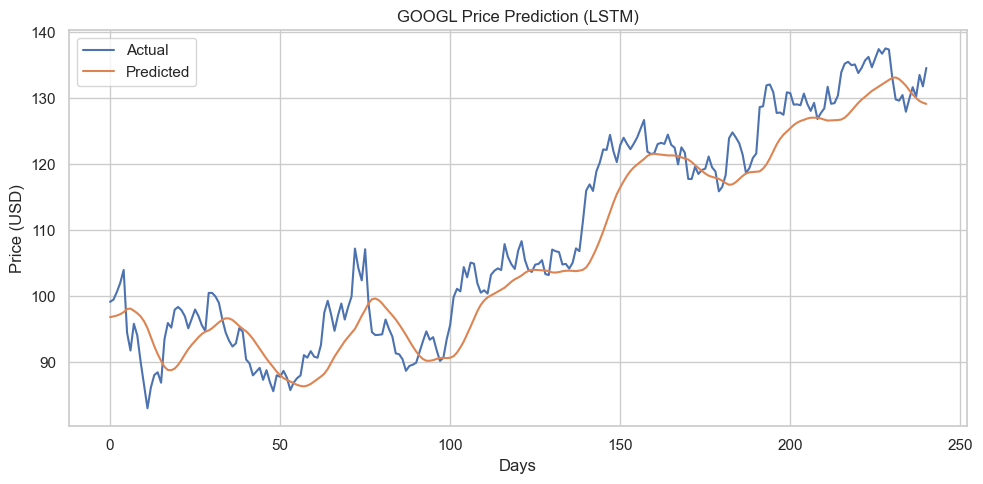

In [35]:
results = {}

for ticker in tickers:
    print(f"\n=== Processing {ticker} ===")
    data = preprocessed_data[ticker]
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    time_step = 60
    train_size = int(len(data_scaled) * 0.8)
    train_data = data_scaled[:train_size]
    test_data = data_scaled[train_size - time_step:]
    X_train, y_train = [], []
    X_test, y_test = [], []
    for i in range(time_step, len(train_data)):
        X_train.append(train_data[i-time_step:i, 0])
        y_train.append(train_data[i, 0])
    for i in range(time_step, len(test_data)):
        X_test.append(test_data[i-time_step:i, 0])
        y_test.append(test_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam())

    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = metrics.mean_absolute_error(actual_prices, predicted_prices)
    rmse = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

    print(f"{ticker} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    results[ticker] = {
        'actual': actual_prices,
        'predicted': predicted_prices
    }

    plt.figure(figsize=(10, 5))
    plt.plot(actual_prices, label='Actual')
    plt.plot(predicted_prices, label='Predicted')
    plt.title(f'{ticker} Price Prediction (LSTM)')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [37]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.
